In [1]:
import torch
import numpy as np 
import scipy

import matplotlib.pyplot as plt
import spatial_maps as sm

from tqdm import tqdm
from models import FFGC, RNNGC
from dataset import DatasetMaker
from plotting_functions import *

In [13]:
def plot_hull(points, hull, ax, *args):
    for simplex in hull.simplices:
        ax.plot(points[simplex, 0], points[simplex, 1], *args)

def smooth_weights(mu, w, bw = 1):
    # Similar to KDE, but not normalized; smooth values spatially
    def kernel(x): 
        d = np.sum((mu[None] - x[:,None])**2,axis=-1)
        return np.sum(w[None]*np.exp(-0.5/bw**2*d), axis = 1)
    return kernel

In [3]:
model = RNNGC()
model = model.load(f"./saved-models/RNNGC_49999.pkl")

In [4]:
phases = np.load("./statistics/RNN_Phases.npy")
grid_scores = np.load("./statistics/RNN_Grid Score.npy")
grid_score_mask = grid_scores > -np.inf

In [5]:
# Convex hull of phases
hull = scipy.spatial.ConvexHull(phases)

In [6]:
timesteps = 10
res = 64
dataset = DatasetMaker()
rt, vt = dataset.generate_data(50000, timesteps)
g = model((rt[:,0], vt)).detach().numpy() # double check that states are alright
ratemaps = scipy.stats.binned_statistic_2d(rt[...,0].ravel().numpy(), rt[...,1].ravel().numpy(), g.reshape(-1, g.shape[-1]).T, bins = res)[0]

In [7]:
x = np.linspace(np.amin(phases), np.amax(phases), res)
xx, yy = np.meshgrid(x,x)
rr = np.stack([xx.ravel(), yy.ravel()], axis=-1)

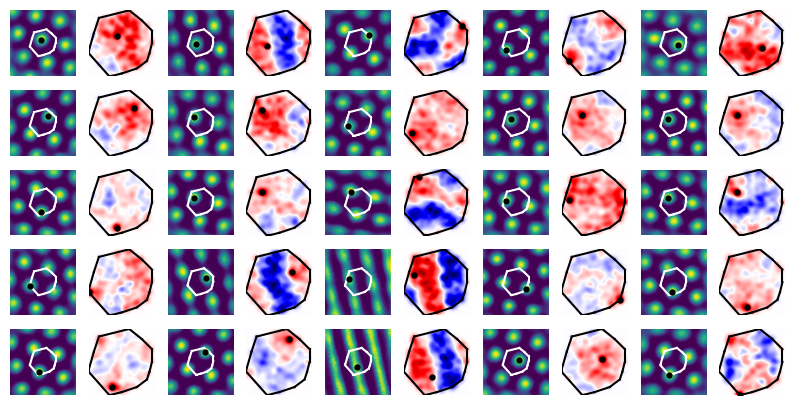

In [33]:
n = 50
fig, ax = plt.subplots(5,10, figsize = (10, 5))
w = model.gg.weight.detach().numpy()[grid_score_mask][:,grid_score_mask].T
axs = ax.ravel()

for i in range(0, n, 2):
        plot_hull(phases, hull, axs[i], "-w")
        plot_hull(phases, hull, axs[i+1], "-k")

        axs[i].imshow(ratemaps[i].T, origin = "lower")
        kde = smooth_weights(phases, w[i], bw = 1)
        lim = np.amax(np.abs(kde(rr)))
        im = axs[i+1].imshow(kde(rr).reshape(res,res), origin = "lower", cmap = "seismic", vmin = -lim, vmax = lim, 
                extent = [np.amin(phases), np.amax(phases), np.amin(phases), np.amax(phases)])
        axs[i].plot(phases[i,0], phases[i,1], "k.", markersize = 7)
        axs[i+1].plot(phases[i,0], phases[i,1], "k.", markersize = 7)
 
        axs[i].axis("off")
        axs[i+1].axis("off")
        axs[i+1].axis("equal")
        # fig.colorbar(im, fraction = 0.045)
        # plt.show()